## Rate limit checks

It seems that a substantial number of tweets is missing from our collection. One possible reason for this is that the crawler runs into rate limits and that at such moments Twitter does not return the tweets which would make the total number of tweets exceed the allowed number within the current time. Twitter's manual  states that this behavior is possible but the exact limit is not mentioned: https://developer.twitter.com/en/docs/tweets/filter-realtime/api-reference/post-statuses-filter

We check the number of tweets collected on Thursday 16 April 2020 by twiqs.nl. This crawler runs four crawlers: track (Dutch tweets), follow (Dutch people), locations (tweets from Dutch-speaking locations) and dialect (tweets written in Dutch dialects). It is possible that the rate limit only affects the total number of tweets collected, so we also examine the sum of the number of collected tweets per time unit (total).

In the logs of the track crawler we found ten mentions of the crawler hitting the date limit.

In [1]:
from datetime import datetime

RATELIMITHITS = ["1586990812990","1587049573673","1587049595569","1587049601794","1587049610358",
                 "1587049620416","1587049624909","1587049632389","1587049646012","1587049659564"]

for timestamp in RATELIMITHITS:
    print(datetime.fromtimestamp(int(timestamp[0:10])))

2020-04-16 00:46:52
2020-04-16 17:06:13
2020-04-16 17:06:35
2020-04-16 17:06:41
2020-04-16 17:06:50
2020-04-16 17:07:00
2020-04-16 17:07:04
2020-04-16 17:07:12
2020-04-16 17:07:26
2020-04-16 17:07:39


In [2]:
TRACK = "track"
FOLLOW = "follow"
LOCATIONS = "locations"
DIALECT = "dialect"
TOTAL = "total"
RATELIMITHIT = "rate limit hit"
STREAMS = [TRACK,FOLLOW,LOCATIONS,DIALECT]

counts = {}
for stream in STREAMS:
    inFileName = "20200416-"+stream+".txt"
    inFile = open(inFileName,"r")
    counts[stream] = {}
    for line in inFile:
        count,time = line.strip().split()
        counts[stream][time] = int(count)
    inFile.close()

In [3]:
counts[TOTAL] = {}
for minute in counts[TRACK].keys():
    counts[TOTAL][minute] = counts[TRACK][minute]
    counts[TOTAL][minute] += counts[FOLLOW][minute] if minute in counts[FOLLOW] else 0
    counts[TOTAL][minute] += counts[LOCATIONS][minute] if minute in counts[LOCATIONS] else 0
    counts[TOTAL][minute] += counts[DIALECT][minute] if minute in counts[DIALECT] else 0

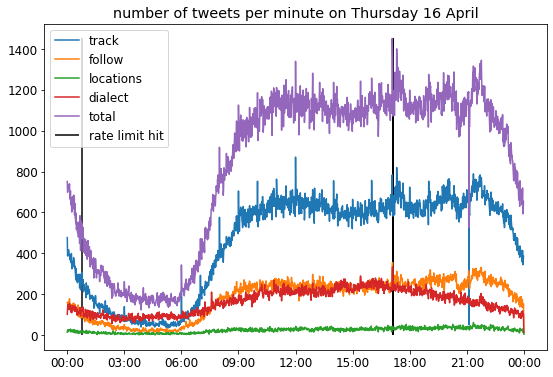

In [5]:
from library import stringArrayToDates
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

font = {"size":12}
matplotlib.rc("font",**font)
myFmt = mdates.DateFormatter('%H:%M')

DATEFORMAT = "%Y%m%d%H%M"

plt.figure(figsize=(9,6))
ax1 = plt.subplot(111)
ax1.xaxis.set_major_formatter(myFmt)
ax1.plot_date(stringArrayToDates(counts[TRACK].keys(),dateFormat=DATEFORMAT),list(counts[TRACK].values()),xdate=True,fmt="-",label=TRACK)
ax1.plot_date(stringArrayToDates(counts[FOLLOW].keys(),dateFormat=DATEFORMAT),list(counts[FOLLOW].values()),xdate=True,fmt="-",label=FOLLOW)
ax1.plot_date(stringArrayToDates(counts[LOCATIONS].keys(),dateFormat=DATEFORMAT),list(counts[LOCATIONS].values()),xdate=True,fmt="-",label=LOCATIONS)
ax1.plot_date(stringArrayToDates(counts[DIALECT].keys(),dateFormat=DATEFORMAT),list(counts[DIALECT].values()),xdate=True,fmt="-",label=DIALECT)
ax1.plot_date(stringArrayToDates(counts[TOTAL].keys(),dateFormat=DATEFORMAT),list(counts[TOTAL].values()),xdate=True,fmt="-",label=TOTAL)
ax1.legend()
for i in range(0,len(RATELIMITHITS)):
    plt.vlines(datetime.fromtimestamp(int(RATELIMITHITS[i][0:10])),0,max(counts[TOTAL].values()),label=RATELIMITHIT if i == 0 else "")
plt.title("number of tweets per minute on Thursday 16 April")
ax1.legend()
plt.show()

In [6]:
def aggregate(countsIn,number):
    countsOut = {}
    sortedKeys = sorted(countsIn.keys())
    for i in range(0,len(sortedKeys)):
        countsOut[sortedKeys[i]] = countsIn[sortedKeys[i]]
        for j in range(i+1,i+number):
            try: countsOut[sortedKeys[i]] += countsIn[sortedKeys[j]]
            except: pass
    return(countsOut)

aggregate({"a":1,"b":2,"c":3,"d":4},2) == {'a': 3,'b': 5,'c': 7,'d': 4}

True

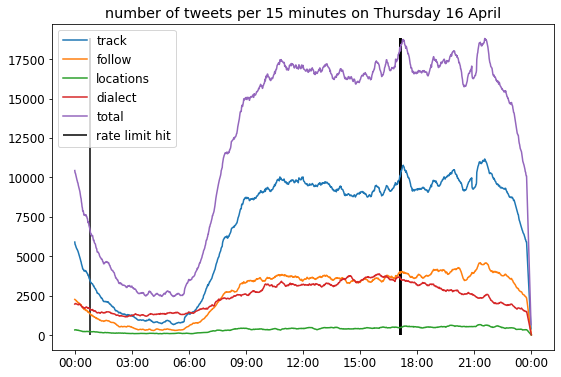

In [7]:
MINS = 15

plt.figure(figsize=(9,6))
ax2 = plt.subplot(111)
ax2.xaxis.set_major_formatter(myFmt)
ax2.plot_date(stringArrayToDates(counts[TRACK].keys(),dateFormat=DATEFORMAT),list(aggregate(counts[TRACK],MINS).values()),xdate=True,fmt="-",label=TRACK)
ax2.plot_date(stringArrayToDates(counts[FOLLOW].keys(),dateFormat=DATEFORMAT),list(aggregate(counts[FOLLOW],MINS).values()),xdate=True,fmt="-",label=FOLLOW)
ax2.plot_date(stringArrayToDates(counts[LOCATIONS].keys(),dateFormat=DATEFORMAT),list(aggregate(counts[LOCATIONS],MINS).values()),xdate=True,fmt="-",label=LOCATIONS)
ax2.plot_date(stringArrayToDates(counts[DIALECT].keys(),dateFormat=DATEFORMAT),list(aggregate(counts[DIALECT],MINS).values()),xdate=True,fmt="-",label=DIALECT)
ax2.plot_date(stringArrayToDates(counts[TOTAL].keys(),dateFormat=DATEFORMAT),list(aggregate(counts[TOTAL],MINS).values()),xdate=True,fmt="-",label=TOTAL)
for i in range(0,len(RATELIMITHITS)):
    plt.vlines(datetime.fromtimestamp(int(RATELIMITHITS[i][0:10])),0,max(list(aggregate(counts[TOTAL],MINS).values())),label=RATELIMITHIT if i == 0 else "")
plt.title("number of tweets per "+str(MINS)+" minutes on Thursday 16 April")
ax2.legend()
plt.show()